<a href="https://colab.research.google.com/github/jrivera15/TallerIADG/blob/main/practicas/Pr%C3%A1ctica4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>🌍 Introducción al análisis de datos geoespaciales con QGIS y Python</center>

### <center>**Práctica 4:**</center>

### <center>Explorar desigualdades espaciales en la ciudad de Hermosillo, Sonora con Python</center>  
<center>
María Janneth Rivera Reyna<br>
Universidad de Sonora<br>
AI-Linkup 2025, Octubre 2025<br>
</center>  
<br>

Objetivo:
Aprender sobre algunas operaciones básicas de geoprocesamiento, visualización de datos en mapas coropléticos, y algunos principios de diseño cartográfico mientras hacemos un análisis de desigualdades espaciales en la ciudad de Hermosillo, Sonora.



## Instalación de librerías

In [ ]:
!pip install geopandas mapclassify

## Importando librerías

In [32]:
import geopandas as gpd
import pandas as pd
import zipfile
import os
import folium

# Mostrar todas las columnas df
pd.set_option('display.max_columns', None)

## Descargando archivos de carpeta compartida en Google Drive


In [ ]:
!gdown --folder 1iED07-5ocrMRfWnLWP4AlvW8RLgbS0cd

### Cargando las capas vectoriales

### Capa: polígonos de colonias a nivel nacional con el Índice de marginación urbana 2020

In [ ]:
# Cargando datos
imc2020 = gpd.read_file("/content/datos/colonias_imc2020.shp")

print(imc2020.shape)
imc2020.head()

In [ ]:
# Revisar el CRS
imc2020.crs

In [ ]:
# Visualización rápida
imc2020.plot()

### Capa: polígono municipio Hermosillo

In [ ]:
# Cargando datos
hmo_mun = gpd.read_file("/content/datos/26mun.shp")

print(hmo_mun.shape)
hmo_mun.head()

In [ ]:
# Revisando CRS
hmo_mun.crs

In [ ]:
# Visualización rápida
hmo_mun.plot()

### Capa: puntos hospitales Hermosillo

In [ ]:
# Cargando datos
hospitales = gpd.read_file("/content/datos/INEGI_DENUE_09102025.shp")

print(hospitales.shape)
hospitales.head()

In [ ]:
# Revisando CRS
hospitales.crs

In [ ]:
# Visualización rápida
hospitales.plot()

## Reproyectar CRS

In [43]:
# Definir sistema de coordenadas de referencia
crs_4326 = "EPSG:4326" # WGS84 lat/lon
#crs_6372 = "EPSG:6372" # MexicoITRF2008/LCC (INEGI) proyectado en metros
#crs_32612 = "EPSG:32612" # UTM Zona 12N proyectado en metros

# Reproyectar al mismo sistema de coordenadas
imc2020_proy = imc2020.to_crs(crs_4326)
hmo_mun_proy = hmo_mun.to_crs(crs_4326)
hospitales_proy = hospitales.to_crs(crs_4326)

## Corregir geometrías

El método <code>buffer(0)</code> corrige errores menores en las geometrías como auto-intersecciones leves, una línea rota, polígonos con agujeros, etc. Para corregir errores más severos existen otros métodos.

In [44]:
# Corregir geometrías inválidas
imc2020_proy["geometry"] = imc2020_proy["geometry"].buffer(0)
hmo_mun_proy["geometry"] = hmo_mun_proy["geometry"].buffer(0)
#hospitales_proy["geometry"] = hospitales_proy["geometry"].buffer(0)

## Cortar método 1: usando límites de un polígono (Clip)

Vamos a recortar la capa de polígonos de colonias, para quedarnos sólo con las que forman parte del municipio de Hermosillo:

In [ ]:
# Recortar el GeoDataFrame
mun_imc2020 = imc2020_proy.clip(hmo_mun_proy)
print(mun_imc2020.shape)

# Visualizar el resultado
mun_imc2020.plot()

## Cortar método 2: filtrando por atributos

En python podemos hacerlo como filtramos un dataframe :

In [ ]:
# Filtrar por NOM_MUN para quedarnos sólo con el municipio de Hermosillo (incluye Miguel Alemán, Bahía de Kino y San Pedro El Saucito)
# También podemos filtrar por NOM_LOC y quedarnos sólo con la localidad de Hermosillo
#hmo_imc2020 = imc2020_proy[imc2020_proy['NOM_MUN'] == 'Hermosillo']
hmo_imc2020 = imc2020_proy[imc2020_proy['NOM_LOC'] == 'Hermosillo']
print(hmo_imc2020.shape)

# Visualizar el resultado
hmo_imc2020.plot()

Hacemos el filtro también para la capa de hospitales:

In [ ]:
# Filtrar por 'municipio' para quedarnos sólo con el municipio de Hermosillo (incluye Miguel Alemán, Bahía de Kino y San Pedro El Saucito)
# También podemos filtrar por 'localidad' y quedarnos sólo con la localidad de Hermosillo
#hmo_hospitales = hospitales_proy[hospitales_proy['municipio'] == 'Hermosillo']
hmo_hospitales = hospitales[hospitales['localidad'] == 'Hermosillo']
print(hmo_hospitales.shape)

# Visualizar el resultado
hmo_hospitales.plot()

## Visualizar mapa coroplético (matplotib)

Con Matplotlib podemos crear un mapa coroplético básico:

In [ ]:
# Definir el orden correcto de los grados de marginación
orden_marginacion = ["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"]

# Convertir la columna a tipo categórico con ese orden
hmo_imc2020["GM_2020"] = pd.Categorical(
    hmo_imc2020["GM_2020"],
    categories=orden_marginacion,
    ordered=True
)

# Mapa coroplético con matplotlib
hmo_imc2020.plot(column='GM_2020',
                 cmap='OrRd',
                 legend=True,
                 categorical = True,
                 figsize=(8, 6),
                 )


##  Unión espacial: Marginación y Hospitales (contar hospitales por colonia)

Primero, vamos a hacer **join espacial**, donde uniremos nuestras dos capas: la de polígonos de colonias y la puntos de hospitales:

In [ ]:
# Join espacial
union_col_hosp = gpd.sjoin(
    hmo_imc2020,
    hospitales_proy,
    how="left",      # mantiene todas las colonias
    predicate="intersects"  # colonias que contienen hospitales
)

print(union_col_hosp.shape)
union_col_hosp.head()

Ahora haremos el conteo de hospitales por colonia:

In [ ]:
# Agrupamos por colonia, haciendo el conteo de número de hospitales
conteo = union_col_hosp.groupby(['COLONIA']).size().reset_index(name='num_hospitales')
print(conteo.shape)
conteo.head()

In [ ]:
conteo['num_hospitales'].max()

Finalmente, unimos el resultado del conteo con las colonias:

In [ ]:
# Unimos el resultado del conteo con las colonias
union_col_hosp = hmo_imc2020.merge(conteo, on='COLONIA', how='left')

# Si hay resultados nulos imputamos con 0
union_col_hosp['num_hospitales'] = union_col_hosp['num_hospitales'].fillna(0)

print(union_col_hosp.shape)
union_col_hosp.head()

In [ ]:
union_col_hosp['num_hospitales'].max()

## Visualizamos el mapa coroplético con Matplotlib

In [ ]:
# Mapa coroplético
union_col_hosp.plot(column='num_hospitales',
                 cmap='Blues',
                 legend=True,
                 figsize=(8, 6),
                 )


## Visualizar mapa coroplético con Folium

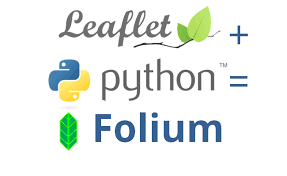

<code>Folium</code> nos permite crear mapas interactivos y más personalizados, ya que podemos manipular los datos en Python, personalizar el diseño con código HTML y la cereza del pastel: visualizar los mapas en la web, a través de  <code>Leafleat.js</code>, una librería Javascript.

In [ ]:
mapa_imc = folium.Map(location=[29.072, -110.955],
               zoom_start=11,
               tiles='CartoDB positron',
               )

# Crear geojson
coropletico_imc = folium.Choropleth(
    geo_data=union_col_hosp,   # gdf que contiene las geometrías.
    data=union_col_hosp,       # gdf que contiene los atributos
    columns=["COLONIA", "IMN_2020"], # Ahora usamos el índice de marginación normalizado (numérico)
    key_on="feature.properties.COLONIA", # Link geometrías por COLONIA
    fill_color="OrRd_r",
    fill_opacity=0.6,
    line_opacity=0.5,
    legend_name="Índice de marginación (numérico)",
).add_to(mapa_imc)

# Tootlips
folium.GeoJsonTooltip(
    fields=["COLONIA", "GM_2020", "IMN_2020"],
    aliases=["Colonia:", "Grado Marginación:", "Índice Marginación:"],
    localize=True
).add_to(coropletico_imc.geojson)

mapa_imc

In [ ]:
# Creamos el mapa
mapa_hospitales = folium.Map(location=[29.072, -110.955],
               zoom_start=11,
               tiles='CartoDB positron',
               )

# Convertir a GeoJSON
coropletico_hospitales = folium.Choropleth(
    geo_data=union_col_hosp,   # gdf que contiene las geometrías. Folium convierte internamente a GeoJSON.
    data=union_col_hosp,       # gdf que contiene los atributos
    columns=["COLONIA", "num_hospitales"], # columnas clave/valor
    key_on="feature.properties.COLONIA", # propiedad del GeoJSON que contiene la clave (COLONIA)
    fill_color="Blues",
    fill_opacity=0.7,
    line_opacity=0.5,
    tooltip=folium.GeoJsonTooltip(fields=['COLONIA', 'num_hospitales']),
    legend_name="Número de hospitales por colonia",
).add_to(mapa_hospitales)

# Creamos tooltips
folium.GeoJsonTooltip(
    fields=["COLONIA", "num_hospitales"],
    aliases=["Colonia:", "Núm. Hospitales:"],
).add_to(coropletico_hospitales.geojson)

mapa_hospitales

In [ ]:
# Creamos el mapa
mapa_imc_hosp = folium.Map(location=[29.072, -110.955],
               zoom_start=11,
               tiles='CartoDB positron',
               )

# Creamos geojson
coropletico_imc = folium.Choropleth(
    geo_data=union_col_hosp,   # gdf que contiene las geometrías.
    data=union_col_hosp,       # gdf que contiene los atributos
    columns=["COLONIA", "IMN_2020"], # Ahora usamos el índice de marginación normalizado (numérico)
    key_on="feature.properties.COLONIA", # Link geometrías por COLONIA
    fill_color="OrRd_r",
    fill_opacity=0.6,
    line_opacity=0.5,
    legend_name="Índice de marginación (numérico)",
).add_to(mapa_imc_hosp)

# Tootlips
folium.GeoJsonTooltip(
    fields=["COLONIA", "GM_2020", "IMN_2020", "num_hospitales"],
    aliases=["Colonia:", "Grado Marginación:", "IMN_2020:", "Núm. Hospitales:"],
    localize=True
).add_to(coropletico_imc.geojson)


# Añadir puntos al mapa (hospitales)
for _, row in union_col_hosp.iterrows():
    geom = row.geometry
    punto = geom.centroid  # obtener el centroide del polígono de colonia

    folium.CircleMarker(
        location=[punto.y, punto.x],
        radius=row["num_hospitales"],
        color="#4651E8",
        opacity=0.7,
        fill=True,
        fill_color="#4651E8",
        fill_opacity=0.7,
        popup=f"<br>Número de hospitales: {row['num_hospitales']}"
    ).add_to(mapa_imc_hosp)

mapa_imc_hosp


#### Exportar mapas

In [58]:
# Guardar como HTML
mapa_imc_hosp.save('mapa_imc_hosp.html')

## Análisis
**1.¿Qué zonas presentan mayor marginación?:** observa el mapa coroplético e identifica los polígonos clasificados como Muy alto o Alto.

**2.¿Coinciden con las periferias o con zonas céntricas?:** compara la localización espacial (usa mapa base: OpenStreetMap) y anota si las áreas marginadas están en la periferia, fragmentadas, cercanas a ríos/zonas de riesgo, etc.

**3.¿A simple vista, ves algún otro patrón?** comenta con tus compañeros.

## Tarea 4

1. Repite la práctica, pero ahora con el municipio de Tuxtla Gutiérrez, Chiapas. (Encuentra el polígono de este municipio en Google drive "mun_tuxtla.shp").
2. Realiza también la parte del análisis y redacta tus conclusiones.
3. Omite toda la parte de los hospitales, ya que ese dataset sólo contiene datos de Hermosillo.
4. Crea tu mapa final con Folium.